# Lab 4:An Introduction of Deep Learning

这个Lab利用MNIST数据集来给大家展示卷积神经网络（CNN）的训练过程，以及如何对于CNN模型进行调优。
同时，通过比较CPU和GPU的训练时间，让大家体会算力在Deep Learning中的作用


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

下面这个脚本告诉你，你是否可以使用GPU进行训练

In [3]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# 1. 图像模型 & LeNet-5

## 1.1 理解tensor的数据类型

Tensor通用shape是(N, H, W, C)，其中N是样本数量，H是高度，W是宽度，C是通道数。
在MNIST数据集中，每个图像是28x28的灰度图，所以通道数C=1。

经验来看，图像数据通常将数据归一化到0-1之间，这样有利于模型的训练。

在Keras中，标签通常使用One-Hot编码，这样有利于计算分类的准确率。

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

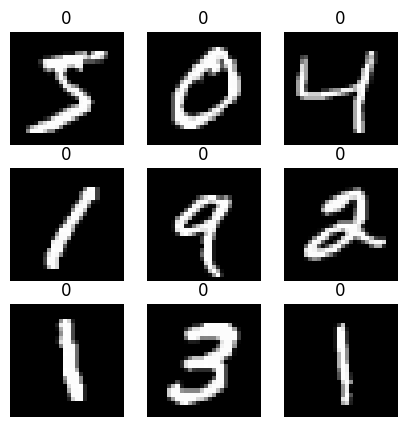

In [5]:
# 原始数据集的图像

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.show()

In [6]:
# 数据归一化
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 标签One-Hot编码
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**思考**：为什么要除255来归一化？


## 1.2. 一个最简单的CNN

下面这个模型是一个最简单的CNN模型

    - “特征工程”：卷积层 + 池化层 + 展平层
    - “分类器”：全连接层

In [9]:
# 初始化模型
model = Sequential()

# 添加卷积层
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))

# 添加池化层
model.add(MaxPooling2D(pool_size=(2, 2)))

# 展平层
model.add(Flatten())

# 全连接层
model.add(Dense(128, activation='relu'))

# 输出层， 10 对应10个类别
model.add(Dense(10, activation='softmax'))

*Ask LLM*：

- 卷积层和池化层的作用是什么？
- 卷积层的kernel_size是什么意思？
- 池化层的pool_size是什么意思？
- 卷积层的activation是什么？



设置训练参数，可以类比ML中的模型参数
- optimizer：常见的有SGD和Adam
- loss：常见的有categorical_crossentropy和MSE
- metrics：常见的有accuracy和f1-score

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


默认使用CPU进行训练

In [11]:
history = model.fit(X_train, y_train, 
validation_data=(X_test, y_test), 
epochs=5, batch_size=128)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8893 - loss: 0.4178 - val_accuracy: 0.9775 - val_loss: 0.0736
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9805 - loss: 0.0663 - val_accuracy: 0.9812 - val_loss: 0.0536
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9873 - loss: 0.0432 - val_accuracy: 0.9824 - val_loss: 0.0522
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9900 - loss: 0.0337 - val_accuracy: 0.9850 - val_loss: 0.0425
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9933 - loss: 0.0232 - val_accuracy: 0.9863 - val_loss: 0.0435


In [ ]:
# 使用GPU训练的方法

with tf.device('/GPU:0'):  
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)


比较训练数据集和验证数据集的准确率，来观察是否需要调整epochs，是否有过拟合。

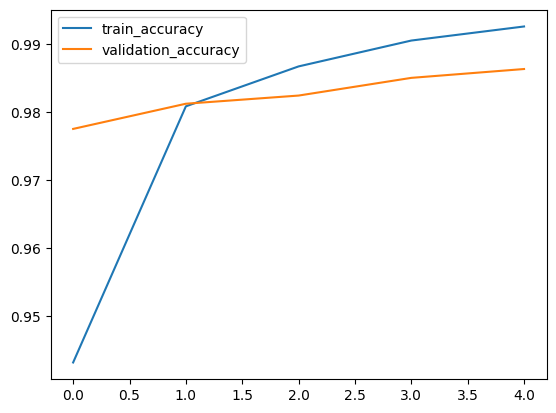

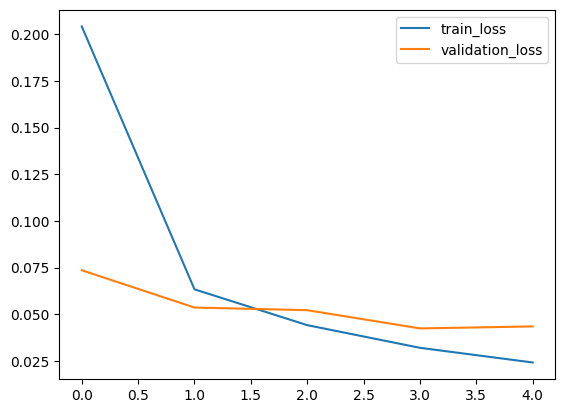

In [12]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

**思考**：如果过拟合了，train loss/validation loss有会有什么模式

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.0537
Test Loss: 0.04350952431559563
Test Accuracy: 0.986299991607666


## 1.3. 架构升级：LeNet-5

LeNet-5是CNN的经典模型，在1998年由Yann LeCun提出，用于手写数字的识别。

**TODO**：比较LeNet-5和上面的最简单的CNN模型，有哪些区别

Deep Learning的模型构建就像搭乐高积木一样，通过不同的积木组合，来测试是否有更好的效果。

除了上面的这三种积木，在序列模型中还有RNN，Transformer，LSTM，GRU等积木。有兴趣的同学可以找到相关的paper，用大模型辅助你去复现一下

In [14]:
# 初始化模型
lenet5 = Sequential()

# 第一个卷积层和池化层
lenet5.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28,28,1), padding='same'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# 第二个卷积层和池化层
lenet5.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# 展平层
lenet5.add(Flatten())

# 全连接层
lenet5.add(Dense(120, activation='tanh'))
lenet5.add(Dense(84, activation='tanh'))

# 输出层
lenet5.add(Dense(10, activation='softmax'))

In [15]:
# 使用SGD优化器
optimizer = SGD(learning_rate=0.01)
lenet5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
history_lenet5 = lenet5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5517 - loss: 1.6205 - val_accuracy: 0.8916 - val_loss: 0.4747
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8932 - loss: 0.4363 - val_accuracy: 0.9218 - val_loss: 0.3023
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9206 - loss: 0.3008 - val_accuracy: 0.9360 - val_loss: 0.2352
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9345 - loss: 0.2421 - val_accuracy: 0.9464 - val_loss: 0.1946
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9451 - loss: 0.1987 - val_accuracy: 0.9524 - val_loss: 0.1680
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9507 - loss: 0.1761 - val_accuracy: 0.9591 - val_loss: 0.1471
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9550 - loss: 0.1571 - val_accuracy: 0.9631 - val_loss: 0.1313
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9604 - loss: 0.1394 - val_accu

**思考**：读了这张图，你会如何决策下一步训练？

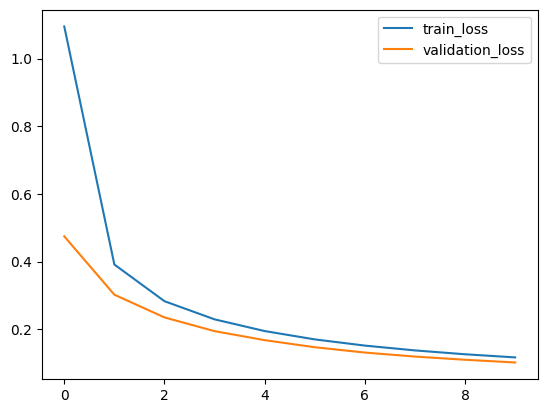

In [17]:
# 绘制准确率曲线
plt.plot(history_lenet5.history['loss'], label='train_loss')
plt.plot(history_lenet5.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = lenet5.evaluate(X_test, y_test)
print(f'LeNet-5 Test Loss: {loss}')
print(f'LeNet-5 Test Accuracy: {accuracy}')


# 2. NLP & Transformer

In [18]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

## 2.1 文本的序列化

- 词元 / Token
- 嵌入向量 / Embedding
    + 捕捉词元的意义及其与其他词元的关系
    +  [Projector](https://projector.tensorflow.org/)
    + 嵌入向量的数学计算带有语义含义
        -  King - Male + Female = Queen
- 位置编码 / Positional Encoding
    + “猫追狗” VS “狗追猫”

In [19]:
# 1. 数据加载和预处理
print("=== 步骤1: 数据加载 ===")

# 加载IMDB数据集，只使用前5000个最常见的词
vocab_size = 5000
max_length = 100  # 限制序列长度以便可视化

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"训练集大小: {len(x_train)}")
print(f"测试集大小: {len(x_test)}")
print(f"第一个样本原始长度: {len(x_train[0])}")
print(f"第一个样本前10个token: {x_train[0][:10]}")

=== 步骤1: 数据加载 ===
训练集大小: 25000
测试集大小: 25000
第一个样本原始长度: 218
第一个样本前10个token: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]


In [20]:
# 2. 展示Token化过程
print("=== 步骤2: Token化演示 ===")

# 获取词汇表映射
word_index = imdb.get_word_index()
# 创建反向映射（从索引到词）
reverse_word_index = {v+3: k for k, v in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = '<UNUSED>'

def decode_review(encoded_review):
    """将token序列转换回文本"""
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

# 展示原始文本和token化结果
sample_idx = 0
print(f"样本{sample_idx}的标签: {'正面' if y_train[sample_idx] == 1 else '负面'}")
print(f"原始token序列前20个: {x_train[sample_idx][:20]}")
print(f"对应的文本: {decode_review(x_train[sample_idx][:20])}")

=== 步骤2: Token化演示 ===
样本0的标签: 正面
原始token序列前20个: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
对应的文本: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you


## 2.2 Transformer架构
- 自注意力机制（self-attention）：保持长距离记忆
    + 把面粉、鸡蛋和牛奶放进搅拌机,将*它*摇匀
- 查询、键和值（**Q**ueries, **K**ey, **V**alue）
    + 查询：它
    + 键：面粉、鸡蛋、牛奶，放进，搅拌机，均匀
    + 值：代表查询/键关系强弱的数字
- Attention
    + $$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
    + 如果你真的好奇原理，推荐[Jay Alammar](https://jalammar.github.io/illustrated-transformer/)

- Encoder / Decoder
    + Encoder：Self-Attention + Feedfoward
    + Decoder：Self-Attention + Encoder-Decoder Attention + Feedward
    + 将encoder和decoder堆叠起来，形成transfomrer；再把transfomer堆叠起来，变成模型架构

- 同构异参：训练的关键是数据量（数量和质量）以及模型参数数量 

In [21]:
# 3. 序列填充和准备
print("=== 步骤3: 序列填充 ===")

# 填充序列到固定长度
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')
# 标签转换为二分类
y_train = np.array(y_train)
y_test = np.array(y_test)

# 4. 简单的Transformer模型定义
print("=== 步骤4: Transformer模型构建 ===")

class SimpleAttention(layers.Layer):
    def __init__(self, d_model, num_heads=1):
        super(SimpleAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """计算注意力权重"""
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        
        # 缩放
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # 添加mask（可选）
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
            
        # softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        output = tf.matmul(attention_weights, v)
        
        return output, attention_weights
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        
        # 计算注意力
        attention, attention_weights = self.scaled_dot_product_attention(q, k, v)
        
        output = self.dense(attention)
        
        # 保存注意力权重用于可视化
        self.last_attention_weights = attention_weights
        
        return output

def create_simple_transformer(vocab_size, max_length, embedding_dim=64):
    """创建简单的Transformer模型"""
    inputs = layers.Input(shape=(max_length,))
    
    # Embedding层
    embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)
    
    # 位置编码（简化版）
    positions = tf.range(start=0, limit=max_length, delta=1)
    positions = layers.Embedding(max_length, embedding_dim)(positions)
    x = embedding + positions
    
    # Transformer块
    attention = SimpleAttention(embedding_dim)
    attended = attention(x)
    
    # 残差连接和层归一化
    x = layers.Add()([x, attended])
    x = layers.LayerNormalization()(x)
    
    # 前馈网络
    ff = layers.Dense(128, activation='relu')(x)
    ff = layers.Dense(embedding_dim)(ff)
    
    # 残差连接和层归一化
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)
    
    # 全局平均池化
    x = layers.GlobalAveragePooling1D()(x)
    
    # 分类层
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model, attention

# 创建模型
embedding_dim = 64
model, attention_layer = create_simple_transformer(vocab_size, max_length, embedding_dim)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

=== 步骤3: 序列填充 ===
=== 步骤4: Transformer模型构建 ===


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │    320,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_attention    │ (None, 100, 64)   │     16,640 │ add[0][0]         │
│ (SimpleAttention)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ simple_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100, 64)   │      8,256 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,585 (1.36 MB)

 Trainable params: 355,585 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# 6. 训练模型（简短训练用于演示）
print("=== 步骤6: 模型训练 ===")

# 使用小批量数据进行快速演示
train_samples = 1000
test_samples = 200

history = model.fit(
    x_train[:train_samples], 
    y_train[:train_samples],
    batch_size=32,
    epochs=3,
    validation_data=(x_test[:test_samples], y_test[:test_samples]),
    verbose=1
)


=== 步骤6: 模型训练 ===
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5237 - loss: 0.7172 - val_accuracy: 0.6150 - val_loss: 0.6362
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7561 - loss: 0.5514 - val_accuracy: 0.6700 - val_loss: 0.6795
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9060 - loss: 0.2992 - val_accuracy: 0.7300 - val_loss: 0.6525


=== 步骤7: 注意力机制可视化 ===
注意力权重形状: (100, 100)


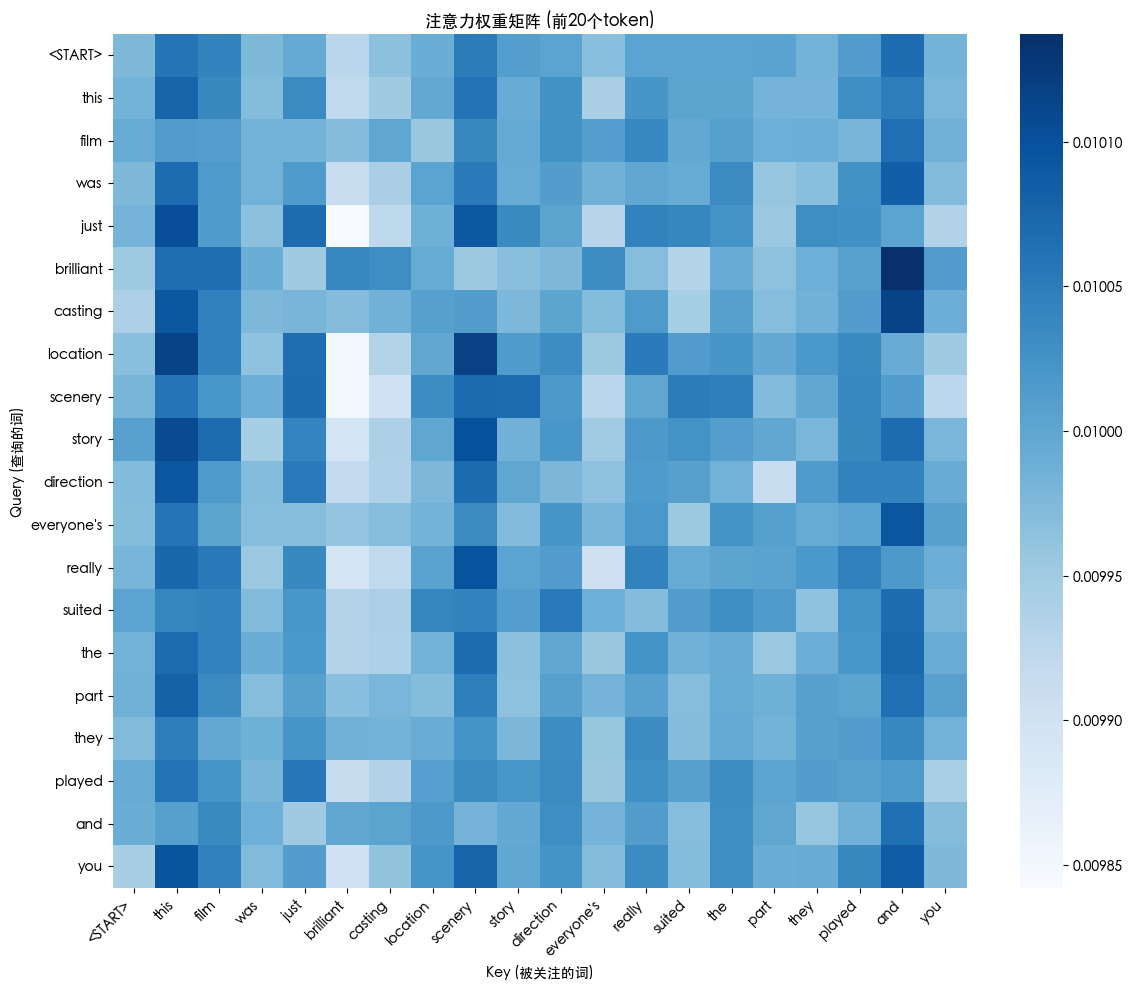


注意力权重解释:
矩阵中的每一行表示一个query词对所有key词的注意力权重
颜色越深表示注意力权重越高
样本文本: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you

示例：第一个词 '<START>' 对其他词的注意力权重:
  对 '<START>' 的注意力: 0.0100
  对 'this' 的注意力: 0.0101
  对 'film' 的注意力: 0.0100
  对 'was' 的注意力: 0.0100
  对 'just' 的注意力: 0.0100


In [24]:
# 7. 可视化注意力矩阵
print("=== 步骤7: 注意力机制可视化 ===")

# 获取一个样本的注意力权重
sample_for_attention = x_train[sample_idx:sample_idx+1]
_ = model(sample_for_attention)  # 前向传播以计算注意力

# 获取注意力权重 - 修复：检查是否已经是numpy数组
attention_weights = attention_layer.last_attention_weights[0]
if hasattr(attention_weights, 'numpy'):
    attention_weights = attention_weights.numpy()  # 如果是tensor则转换
# 如果已经是numpy数组，直接使用

print(f"注意力权重形状: {attention_weights.shape}")

# 只显示前20x20的注意力矩阵以便观察
seq_len_to_show = min(20, attention_weights.shape[0])
attention_subset = attention_weights[:seq_len_to_show, :seq_len_to_show]
tokens_subset = sample_for_attention[0, :seq_len_to_show]

# 确保tokens_subset也是numpy数组
if hasattr(tokens_subset, 'numpy'):
    tokens_subset = tokens_subset.numpy()

words_subset = [reverse_word_index.get(int(token), '<PAD>') for token in tokens_subset]

plt.figure(figsize=(12, 10))
sns.heatmap(
    attention_subset,
    xticklabels=words_subset,
    yticklabels=words_subset,
    cmap='Blues',
    annot=False,
    fmt='.2f'
)
plt.title('注意力权重矩阵 (前20个token)')
plt.xlabel('Key (被关注的词)')
plt.ylabel('Query (查询的词)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 显示具体的注意力值
print("\n注意力权重解释:")
print("矩阵中的每一行表示一个query词对所有key词的注意力权重")
print("颜色越深表示注意力权重越高")
print(f"样本文本: {decode_review(tokens_subset)}")

# 显示一些具体的注意力值示例
print(f"\n示例：第一个词 '{words_subset[0]}' 对其他词的注意力权重:")
for j in range(min(5, len(words_subset))):
    print(f"  对 '{words_subset[j]}' 的注意力: {attention_subset[0, j]:.4f}")

In [25]:
# 8. 模型预测和解释
print("=== 步骤8: 模型预测演示 ===")

# 预测几个样本
test_samples_for_pred = x_test[:5]
predictions = model.predict(test_samples_for_pred)

for i in range(5):
    actual_label = "正面" if y_test[i] == 1 else "负面"
    predicted_prob = predictions[i][0]
    predicted_label = "正面" if predicted_prob > 0.5 else "负面"
    
    print(f"\n样本 {i+1}:")
    print(f"文本片段: {decode_review(test_samples_for_pred[i][:30])}")
    print(f"实际标签: {actual_label}")
    print(f"预测概率: {predicted_prob:.4f}")
    print(f"预测标签: {predicted_label}")
    print(f"预测{'正确' if actual_label == predicted_label else '错误'}")

=== 步骤8: 模型预测演示 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

样本 1:
文本片段: <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast <UNK> terrible performances the show is flat flat flat br br i don't
实际标签: 负面
预测概率: 0.4934
预测标签: 负面
预测正确

样本 2:
文本片段: <START> this film requires a lot of <UNK> because it focuses on mood and character development the plot is very simple and many of the scenes take place on the
实际标签: 正面
预测概率: 0.8800
预测标签: 正面
预测正确

样本 3:
文本片段: <START> many animation buffs consider <UNK> <UNK> the great forgotten genius of one special <UNK> of the art <UNK> animation which he <UNK> almost single <UNK> and as it happened
实际标签: 正面
预测概率: 0.9867
预测标签: 正面
预测正确

样本 4:
文本片段: <START> i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it
实际标签: 负面
预测概率: 0.0115
预测标签: 负面
预测正确

样本 5:
文本片段: <START> like some other people wrote i'm a die hard mario fan and i loved this game br br

## 2.3 Decoder Only & GPT

- Decoder Only架构：只看上文，不看下文 -> next token prediction
- 在参数量极大的情况下依然能够保留长距离记忆

# 回家作业【选做】：以MNIST炼一炉丹

和ML选型相对还有一些数学直觉和验证之外，DL的参数选型的反馈只有通过数据集的验证才能看到结果。

这种方式非常接近中世纪化学发明前的Alchemy，所以DL也被称为“炼金术”，DL研究人员戏称自己为“炼丹师”。

你可以挑选一些参数，来观察他们的变化对模型训练的影响。

    - 模型架构：增加卷积层，改变activation方式，改变kernel size和stride
    - 优化器：SGD，Adam[基本是标配]，AdamW；学习速率
    - 损失函数：categorical_crossentropy[基本是标配]，MSE
    - 训练过程：epochs，batch size
